# Semester project: Report

**By: Ben Haj Yahia AHMED**

**Section: Data Science, Master 3**

**Sciper°: 261317**

**email: ahmed.benhajyahia@epfl.ch**

# bmAi : Artificial intelligence against malnutrition

![alt text](bmai.PNG)

## Context

**Malnutrition** is still widespread in the world. Assessing the **height and weight** of children is essential to determine their **nutritional status**. It seems an easy task. In reality, it is challenging since **Images are obtained in an unconstrained setting:**
- Location and orientation of the camera.
- Background.
- Lighting conditions.
- Image resolutions
- Pose of the child (newborns).
- Clothes worn by the child.

**Body measurements** are an essential tool for medical diagnosis and treatment, e.g., to **assess the nutritional status** of people, to **estimate disease risk**, and to **detect specific medical conditions**.

However, these measurements are often **difficult** to realize in practice, especially with **children**, and, as a result, are often **imprecise and unreliable**. Additionally, in many developing countries of today’s world, **scales and measuring boards are becoming scarcer than mobile phones**.

Several alternatives to traditional body measurement methods have been developed, but to date there are no real appropriate solutions.

## Goal

The goal of this project is to develop a **Deep Learning solution that can estimate body measures from mobile phone pictures with unconstrained settings** in a rapid, easy, automatic, reproducible, and accurate manner.

More precisely, we will develop a **mobile application** that can **estimate the height, weight** and nutritional status of children under 5 years of age for developing countries.

In order to do this, we are using state-of-the-art **image processing** and **machine learning** techniques. And, to avoid the need to use **external servers**, the best way is to deploy a **MobileNet model**.

**Long term objectives:**

- Develop mobile applications that can **estimate body measures from mobile phone pictures** in a rapid, easy, automatic, reproducible, and accurate manner.

**Short term objectives:**

- Obtain a model achieving a **relative error smaller than 5%** on the height and weight predictions. 
- The priority is given to **newborns** from Guinea.

To solve the task, the **model must learn image representations**:
- **Invariant** to the aforementioned **variations**.
- Retaining the **predictive attributes**.

## Related work

Several approaches were previously tested by those who worked on the project. And, as explained before, the use of Mobilenet is the best alternative to deploy it easily in a mobile application. **The idea is to use a model trained for a similar task and with a large dataset.** $\Rightarrow$ The similar task is **pose estimation.**

### a) OpenPose

**OpenPose** is the first open-source realtime system for [**multi-person 2D pose detection**](https://arxiv.org/pdf/1812.08008.pdf), including body, foot, hand, and facial keypoints.

In our case, we will use a **Lightweight version of OpenPose**, from [Real-time 2D Multi-Person Pose Estimation on CPU: Lightweight OpenPose](https://arxiv.org/pdf/1811.12004.pdf). This work heavily optimizes the OpenPose approach to reach real-time inference on CPU with negliable accuracy drop.

OpenPose uses **VGG-19** to generate Feature Maps F that is input a **CPM ([Convolutional Pose Machines](https://arxiv.org/pdf/1602.00134.pdf))** which is then fed to the **Initial stage**. At this stage,
the network produces a set of part **affinity fields (PAFs)** and **confidence maps**. The subsequent stages are referred to as **Refinement Stages** In each subsequent stage, the predictions from the previous stage and the original image features F are concatenated and used to produce refined predictions. 

The difference between the main OpenPose model and its Lightweight version is that in the lightweight version the **VGG-19** model is replaced by a **mobilenet_v1**. The number of **Refinements Stages** are also reduced **from 5 to 1**.

The **Lightweight OpenPose model** expects as input a **3-channel image (BGR)** and was trained on **normalized (256x256)** images.  The output consists of :
1. **J+1** channels, each ***j*** channel conists of a heatmap of a joint with **J** the chosen number of joints. The additional channel (last channel) contains a concatenated heatmap of all joints (as shown below)
2. A list of **P images, each represents of Part Affinity Field (PAF)** These are then used to link the joints.
    
(Note: J and P are input parameters)

Example of output of the OpenPose method, with J = 19 and P = 38 (the 38 images of representing the PAFs are summed)
![alt text](example_output_openpose.png)

### b) Methods:
1. **Linear Regression** : ![alt](linear_regression_method.png)

    - Features are the **estimated length and width** of the limbs and the **body mask perimeter and area**. 
    - **Tennis ball** is used to **scale the features**.
    - Easily interpretable.
    - Can easily accommodate **custom loss functions** to achieve specific objective of predictions of height and weight
    
     **Disadvantages**:
        - makes relatively **strong assumptions** on the underlying data distribution.
        - Has the tendency to predict the average height/weight.
        - Not robust against occlusionn.
        - requires a reference object (tennis ball).
        
     **Loss**:
        - A **custom loss function** which is in alliance with the goal of the project, is to **only penalize predictions** of height and weight that **vary more than 5% from the true values**. This custom loss function will be used throughout the project and is **defined as** : 
    
            Loss :

\begin{equation}
\mathscr{L} = \frac{1}{\sum_{i}{} w_i \frac{| y_i - \hat{y_i} |}{y_i } }
\end{equation}

            Weights: 
$$
w =
\left\{
\begin{array}{@{}@{}}
 | y_i - \hat{y_i} | \space \space & if \space \frac{| y_i - \hat{y_i} |}{y_i } > 5\% \\
 0 & if \space \frac{| y_i - \hat{y_i} |}{y_i } 	\leq 5\% 
\end{array}
\right.
$$



    
     

    
2. **K-Nearest Neighbors**:
    - Estimation is based on a **weighted average** of the **closest K samples** in the database. 
    - **Similarity between samples** relies on the **same features** as for linear regression.
    - Model is intrinsically **more robust to outliers** as they are by definition far from the other samples. 
    - Mitigates the problem of having **different models** based on **region or age** of the child.
    
     **Disadvantages**:
        - Needs to store a database of the existing samples in the application.
        - Less interpretable than linear regression.
    
    
    
3. **Second model, based on OpenPose features** :
    - Contains **same information as the previous models**, with additional information about **relative position of each limbs**.
    - The **ball mask** provides information w.r.t. **the scaling and the compression** in each direction **(H, W)**.
    - Relevant features are extracted with a **convolutional architecture**.
    - **Prediction of height and weight** with a single model.

![alt](second_model_example.png)
    

#### Imports 

In [6]:
import pandas as pd
from skimage import io
import numpy as np
import torch
from utils import * 
from matplotlib import pyplot as plt
import seaborn as sns

## Data

In [86]:
guinee = pd.read_csv('bmai_ahmed/data/full_guinee_data.csv')
cambodge = pd.read_csv('bmai_ahmed/data/full_cambodge_data.csv')
print(f'The data consists of two different datasets of children images, one containing {len(guinee)} images of new-born children with age between {min(guinee.days)} and {max(guinee.days)} days while the other contains {len(cambodge)} images of a bit older children from cambodge with age between {min(cambodge.days)} and {max(cambodge.days)} days')

The data consists of two different datasets of children images, one containing 766 images of new-born children with age between 1 and 40 days while the other contains 6941 images of a bit older children from cambodge with age between 6 and 2388 days


Let's vizualize some of the images we have.

In [87]:
gui_1 = io.imread('guinee_example_1.jpg')
gui_2 = io.imread('guinee_example_2.jpg')
gui = [gui_1,gui_2]

cam_1 = io.imread('cambodge_example_1.JPG')
cam_2 = io.imread('cambodge_example_2.JPG')
cam = [cam_1,cam_2]

examples = [cam,gui]

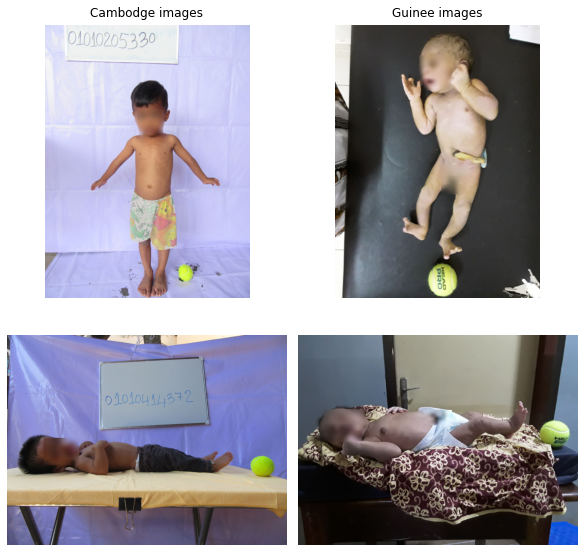

In [88]:
fig = plt.figure(constrained_layout=True,figsize=(8,8))
data_name = ['Cambodge','Guinee']
# create 1x2 subfigs
subfigs = fig.subfigures(nrows=1, ncols=2)
for col, subfig in enumerate(subfigs):
    subfig.suptitle(f'{data_name[col]} images')
    imgs = examples[col]
    # create 2x1 subplots per subfig
    axs = subfig.subplots(nrows=2, ncols=1)
    for row, ax in enumerate(axs):
        ax.imshow(imgs[row])
        ax.axis('off')
        #ax.set_title(f'Guinee images {row}')

### Guinee

For guinee, images are of new born childs. Thus, they are always in a lying position and mainly capture the front side.

In [163]:
print(f"Heights are between {guinee.height.min()}cm and {guinee.height.max()}cm, with mean height = {round(guinee.height.mean(),2)}")
print(f"Weights are between {guinee.weight.min()}kg and {guinee.weight.max()}kg, with mean weight = {round(guinee.weight.mean(),2)}")
print(f"Ages are between {guinee.days.min()}days and {guinee.days.max()}days, with mean weight = {round(guinee.days.mean(),2)}")

Heights are between 38cm and 57cm, with mean height = 49.27
Weights are between 0.99kg and 5.5kg, with mean weight = 2.94
Ages are between 1days and 40days, with mean weight = 9.34


In [191]:
display(guinee.sexe.value_counts())
print("We can say that guinee data is BALANCED in SEX attribute")

1    396
0    370
Name: sexe, dtype: int64

We can say that guinee data is BALANCED in SEX attribute


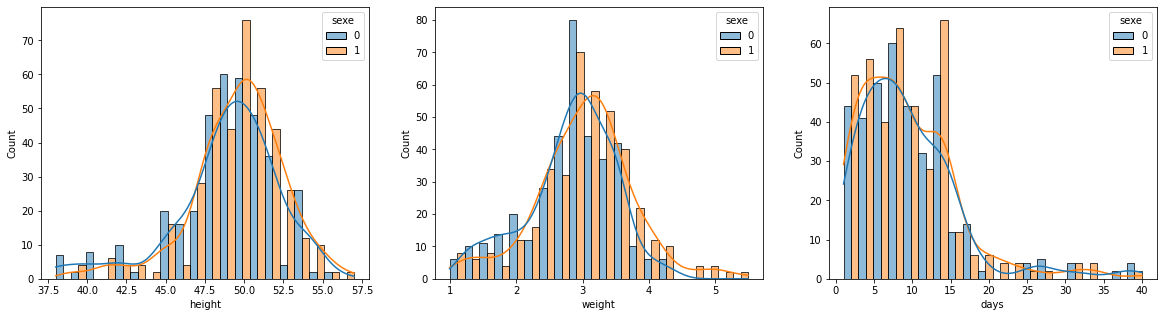

In [161]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,5))

sns.histplot(data=guinee,x='height',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[0])
sns.histplot(data=guinee,x='weight',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[1])
sns.histplot(data=guinee,x='days',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[2]);

- We can see that **heights** are almost **normally distributed**, with values well concentrated around the mean. **Outliers** are more present **towards the left**, which mean that they represent **under-height childs**.

- **Weights** are also almost **normally distributed** around the mean, but with a quite **high number of under-weight** children.

- Age distribution is **right-skewed normal distribution**.

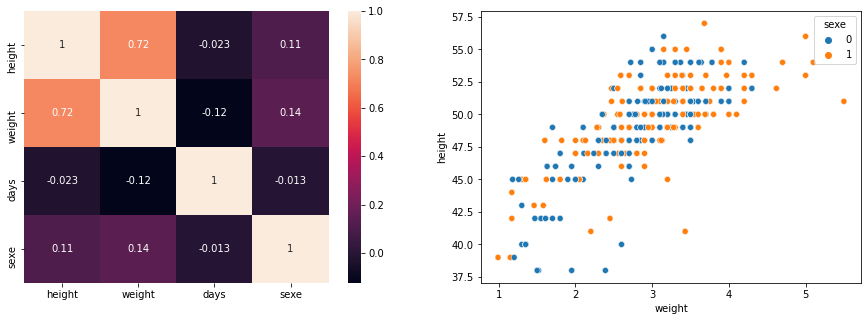

In [184]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
sns.heatmap(guinee[['height','weight','days','sexe']].corr(),annot=True,ax=axs[0])
sns.scatterplot(data=guinee,x='weight',y='height',hue='sexe',ax=axs[1]);

As we could imagine, we can see from the heatmap that **Height and Weight are highly correlated**. This can be confirmed with the shape of the scatter plot which have an **ascending diagonal line shape**. For new borns, we can see that **SEX** has a **weak positive correlation with height and weight**, and **Age** is almost **uncorrelated with height** and has a **weak negative correlation with weight**, which is a bit suprising since a new born should normally **gain between 0.5kg and 1kg in a month**.

### Cambodge 
![alt](cambodge_front_side.png)
For cambodge, images are of childs with a wide range of ages. Thus, the data contains images of babies in a lying position, but have mainly images of standing children. For almost each child, this dataset captures front and side images: 


In [194]:
print(f"Heights are between {cambodge.height.min()}cm and {cambodge.height.max()}cm, with mean height = {round(cambodge.height.mean(),2)}cm")
print(f"Weights are between {cambodge.weight.min()}kg and {cambodge.weight.max()}kg, with mean weight = {round(cambodge.weight.mean(),2)}kg")
print(f"Ages are between {cambodge.days.min()}days and {cambodge.days.max()}days, with mean weight = {round(cambodge.days.mean(),2)}days")

Heights are between 44.75cm and 110.6cm, with mean height = 82.36cm
Weights are between 2.5kg and 22.8kg, with mean weight = 10.36kg
Ages are between 6days and 2388days, with mean weight = 855.32days


In [192]:
display(cambodge.sexe.value_counts())
print("We can say that cambodge data is BALANCED in SEX attribute")

0    3592
1    3349
Name: sexe, dtype: int64

We can say that cambodge data is BALANCED in SEX attribute


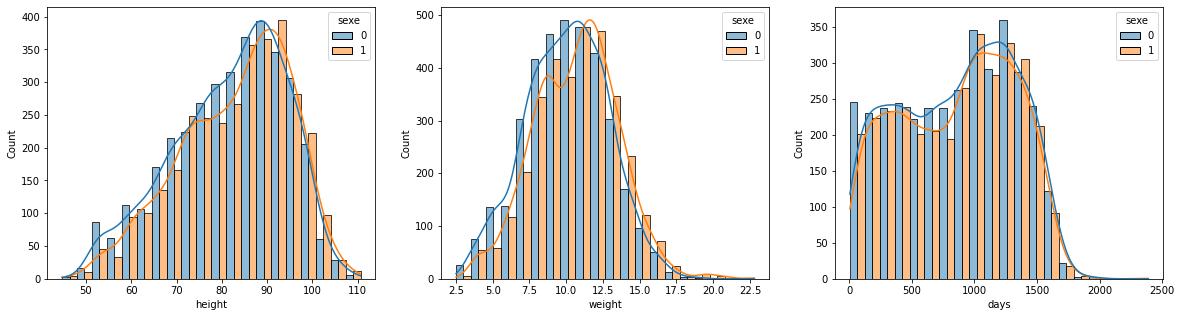

In [200]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,5))

sns.histplot(data=cambodge,x='height',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[0])
sns.histplot(data=cambodge,x='weight',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[1])
sns.histplot(data=cambodge,x='days',hue='sexe',kde=True,bins=20,multiple='dodge',ax=axs[2]);

- We can see that **heights**'s shape is a **left-skewed normal distribution**  with a Mode value of 92cm which is 10cm higher than the mean.

- **Weights** are also almost **normally distributed** around the mean.

- **Age** distribution seems as if two samples of children were measured and can be classified to **under 2 years and over 2 years**.

In [ ]:
## fig,axs = plt.subplots(1,2,figsize=(15,5))
sns.heatmap(cambodge[['height','weight','days','sexe']].corr(),annot=True,ax=axs[0])
sns.scatterplot(data=cambodge,x='weight',y='height',hue='sexe',ax=axs[1]);

For **cambodge** data, we can see that **height and weight are highly correlated** and these attributes are more correlated than in guinee data with **corr=0.94 against 0.72**. As in guinee, **SEX** attribute is almost **uncorrelated with height and weight**. Notice that, here, **AGE** attribute is **highly correlated with both height and weight**. This is expected since **cambodge data** have children with a **wide range of ages**.


### Data preprocessing

For both **guinee and cambodge** datasets, images are in **different sizes**. A **fixed size of (256x256)** was selected for input images, and all images were **resized to those dimensions**. Note that **the aspect ratio remains unchanged** by using **padding** on the resized images. 

![alt](rescale_pad_example.png)

## I- Pretrained lightweight OpenPose model

By performing **Transfer Learning** on the **lightweight version of OpenPose** model which uses **Mobilenet_v1**, we started by using it as a whole as Feature Extractor, and thus the **PAFs as input** to our simple regression model shown below, consisting of a **Flatten** and multiple **Fully connected layers**, where the last one outputs (Height, Weight)
![alt text](simple_predictive_model.png)



By training this model with **Adam optimizer** for **30 epochs**, using a **batch size of 128** and a **learning rate of 0.05**, with a **train_test split of (0.8,0.2)** for **4 different seeds**, we obtained as **average results** :

In [6]:
full_openpose_results = pd.read_csv('bmai_ahmed/results/Full_OpenPose_bmai_results.csv',names=['data','IMG_SIZE','AGE','SEX','SEED','epochs','lr','mean_height_rel_error','mean_weight_rel_error']).drop(columns=['AGE','SEX','SEED','epochs','lr','IMG_SIZE'])
full_openpose_results

,data,mean_height_rel_error,mean_weight_rel_error
0,guinee,0.461858,0.476739
1,cambodge,0.205611,0.286572
2,guinee_cambodge,0.215530,0.433993


***Analysis :***

As expected, the model **did not perform well**. **Without any data augmentation** (apart from **Normalization**), on **Guinee data**, and using only **766 images**, the model had roughly **50% relative error** from the true values of **both height and weight**. Maybe it is because the data is not enough for a model of this complexity.

On **cambodge data** on the other hand, being trained on **6941 images** led to **better results** with **20% relative error from the true values**. This is still a bad result, but when using as input the PAFs image, we **lose a lot of information** and the regression only uses **connected joints** to make its prediction and this seems to be **not enough**.

So, as a next step, we will vizualize **feature maps** of the model and manually select where to stop in our feature extractor.

### a) Features maps

For the same input image used above, we vizualized the output of each layer. Here we show some of these vizualizations with their corresponding phase.

![alt text](feature_maps.png)


Using these 4 feature maps, we created **4 models** with same regression part but with **different inference models**, each one will stop in one of those 4 steps:
1. **Baseline_1** : Inference model stops halfway through Mobilenet_v1.
2. **Baseline_2** : Inference model stops at the end of Mobilenet_v1.
3. **Baseline_3** : Inference model stops after CPM.
4. **Baseline_4** : Inference model stops after Initial Stage.



### b) Data Augmentation

Before runnig our models, we do Data Augmentation by applying to our images a list of transformations. Each of these transformations is applied randomly with probability 0.5 . These transformations with their corresponding resulting image are shown below.

![alt](transformations.png)

### c) Models and results

We started by training those 4 baselines models on our two datasets, in both freeze mode and without freeze mode. The results are summurized in the table below.

In [217]:
baselines_results = pd.read_csv('baselines_results.csv')
baselines_results_freeze = baselines_results[baselines_results.freeze==True] 
baselines_results_freeze

,model,freeze,data,MeanRelativeError_Height,MeanRelativeError_Weight
0,baseline1,True,guinee,0.055013,0.254317
1,baseline2,True,guinee,0.052735,0.230460
2,baseline3,True,guinee,0.060117,0.278334
3,baseline4,True,guinee,0.062337,0.292413
4,baseline1,True,cambodge,0.076448,0.239852
5,baseline2,True,cambodge,0.074207,0.233132
6,baseline3,True,cambodge,0.084839,0.286083
7,baseline4,True,cambodge,0.080696,0.266750


In [218]:
baselines_results_Nofreeze = baselines_results[baselines_results.freeze==False] 
baselines_results_Nofreeze

,model,freeze,data,MeanRelativeError_Height,MeanRelativeError_Weight
8,baseline1,False,guinee,0.058013,0.224317
9,baseline2,False,guinee,0.050948,0.217761
10,baseline3,False,guinee,0.054117,0.257346
11,baseline4,False,guinee,0.052377,0.277541
12,baseline1,False,cambodge,0.081448,0.209852
13,baseline2,False,cambodge,0.073118,0.205130
14,baseline3,False,cambodge,0.085481,0.248122
15,baseline4,False,cambodge,0.090732,0.266274


#### We can see from the two dataframes above, that overall, Baseline 2 which is Mobilenet_v1 is the most performant model.

**Comparison of Full OpenPose model and Mobilenet_v1**:

- Compared to the results we had using **OpenPose model**, we can see that the performance have **improved a lot**, using **mobilenet_v1** as backbone. We now have for **guinee data**, a **mean height relative error** of **0.05**, against **0.46** before. we also improved the predictions of **the weight**, which has gone **from 0.47 to approximately 0.22**. The same is true for **Cambodge data**, with **mean height relative error** of **0.074**, against **0.20** before, and with **mean weight relative error** which has gone **from 0.28 to approximately 0.20**.

![alt](comparison_for_guinee_data.png)

**Note that**: Although it did perform well when trained on **guinee data** only, **Mobilenet_v1** tend to always predict the **mean height and weight**. As you can see below, the model have a **MRE of 5% in height and 21.7% in weight**, but the **data itself** has a **Mean Relative difference from the mean of 4.95% in Height and 22.3% in Weight**.

**Baseline_2 with Non-Freezed inference model, on guinee only**:

In [222]:
print(f'Mean height relative error = {model_2_No_Freeze_guinee_only_results.height_relative_error.mean()}')
print(f'Mean weight relative error = {model_2_No_Freeze_guinee_only_results.weight_relative_error.mean()}')
display(model_2_No_Freeze_guinee_only_results.drop(columns=['Unnamed: 0']).head())
mean_h = guinee.height.mean()
rel_diff = np.abs((guinee.height - mean_h)/guinee.height)
print(f'Mean relative difference in height for Guinee\'s new born childs is {round(rel_diff.mean(),4)}')
print(20*'-')
mean_w = guinee.weight.mean()
rel_diff = np.abs((guinee.weight - mean_w)/guinee.weight)
print(f'Mean relative difference in height for Guinee\'s new born childs is {round(rel_diff.mean(),4)}')

Mean height relative error = 0.050947984763500015
Mean weight relative error = 0.21776071838497008


,predicted_height,predicted_weight,true_height,true_weight,height_relative_error,weight_relative_error
0,46.507504,2.793334,47.0,2.24,0.010479,0.247024
1,48.218727,2.898708,50.0,3.80,0.035625,0.237182
2,50.814255,3.052701,50.0,3.00,0.016285,0.017567
3,48.302795,2.903567,50.0,3.10,0.033944,0.063366
4,50.171326,3.026663,51.0,3.50,0.016249,0.135239


Mean relative difference in height for Guinee's new born childs is 0.0495
--------------------
Mean relative difference in height for Guinee's new born childs is 0.2232


#### So as a next step, we will focus on Mobilenet_v1 and try to achieve better performance on guinee data. The idea is to train the model on Cambodge then fine tune it on guinee:

Here, Mobilenet_v1 Model (Baseline_2) was trained **N full epochs on cambodge**, then **Q finetuning epochs on guinee**, with N and Q being hyperparameters that we tune in by **cross Validation**. Since our priority is to perform well on **newborns from Guinee**, we chose here to always **test on Guinee data only**. And since compared to the number of images we have from Cambodge, Guinee data is **less represented** and thus we needed a **higher number of epochs (Q)** when going through it.

We used **Adam optimizer**, a **batch size of 128** and a **learning rate of 0.05**. For each Baseline model, we tried **Freezing its inference model and without freezing it**. Here are the sorted results :

PS: We found that the model performs pretty well when predicting the height, but have issues dealing with Weight, so we sorted the results by ascending relative weight error
##### Sorted results of our two baseline models in freeze mode :  


In [7]:
OpenPose_sorted_results = pd.read_csv("OpenPose_sorted_results.csv")
OpenPose_sorted_results_freeze = OpenPose_sorted_results[OpenPose_sorted_results.freeze==True]
OpenPose_sorted_results_freeze.head(10)

,model,freeze,full_epochs,finetune_epochs,MeanRelativeError_Height,MeanRelativeError_Weight
0,baseline1,True,0,30,0.060479,0.202267
1,baseline2,True,2,50,0.054037,0.205129
2,baseline2,True,1,50,0.052257,0.205472
3,baseline2,True,3,10,0.055515,0.206161
4,baseline1,True,2,10,0.057554,0.206272
5,baseline2,True,3,40,0.050471,0.206355
6,baseline1,True,2,20,0.054913,0.206823
7,baseline2,True,3,50,0.050051,0.208581
8,baseline1,True,1,40,0.058697,0.209995
9,baseline1,True,0,20,0.054842,0.210978


##### Sorted results of our two baseline models without freeze :  


In [11]:
OpenPose_sorted_results_Nofreeze = OpenPose_sorted_results[OpenPose_sorted_results.freeze==False]
OpenPose_sorted_results_Nofreeze.head(10)

,model,freeze,full_epochs,finetune_epochs,MeanRelativeError_Height,MeanRelativeError_Weight
59,baseline2,False,2,50,0.052568,0.183889
60,baseline2,False,2,30,0.066184,0.207843
61,baseline2,False,2,20,0.059502,0.211804
62,baseline2,False,0,40,0.070729,0.214701
63,baseline2,False,0,50,0.056274,0.215638
64,baseline2,False,3,10,0.073284,0.216522
65,baseline2,False,1,10,0.064076,0.217175
66,baseline2,False,1,30,0.058540,0.221004
67,baseline1,False,0,40,0.081310,0.226081
68,baseline2,False,3,50,0.052775,0.226485


In [13]:
OpenPose_sorted_results_Nofreeze[OpenPose_sorted_results_Nofreeze.model=='baseline2'].rename(columns={'full_epochs':'C','finetune_epochs':'G'}).head(10)

,model,freeze,C,G,MeanRelativeError_Height,MeanRelativeError_Weight
59,baseline2,False,2,50,0.052568,0.183889
60,baseline2,False,2,30,0.066184,0.207843
61,baseline2,False,2,20,0.059502,0.211804
62,baseline2,False,0,40,0.070729,0.214701
63,baseline2,False,0,50,0.056274,0.215638
64,baseline2,False,3,10,0.073284,0.216522
65,baseline2,False,1,10,0.064076,0.217175
66,baseline2,False,1,30,0.058540,0.221004
68,baseline2,False,3,50,0.052775,0.226485
70,baseline2,False,0,10,0.080443,0.226844


The **best performances** that we now have is when using **Baseline_2** wich is a **Mobilenet_v1** with **2 epochs on Cambodge** images and **50 epochs on Guinee**. This model achieves a **mean height relative error and mean weight relative error of 5.4% and 20.5%** respectively when backbone is **freezed** and it achieves **5.2% and 18.3%** when backbone is **not freezed.**

### d) Analysis

**Mobilenet_v1 (Baseline_2) finetuned on guinee**:
- We can see that training our model on Cambodge data then **finetuning** it on guinee data **didn't have a huge impact on the results** since there is only a **2% better weight prediction**. **Height MAE** remained the same as before **(5.2%)** on guinee test data, knowing that now, the model's behavior **doesn't predict the mean** like it did when trained on guinee data only 

**Difference between freezed and non-freezed backbone**:
- We can see that, Baseline_2 **with Freezed inference model** performed **slightly better in predicted the height**, but with **non-freezed inference model**, the results for **the weight predictions are better**.

We are still **not satisfied** with the performances of our model, espacially when **estimating Width**. Having a relative error of **18.3% is too high**. For **Height predictions**, our resulting relative error is roughly **5.2%**, which is still not lower than the **5% threshold** we set at the start of the project.

**Drawbacks**:
- Bad performance when estimating Weight
- Mobilenet_v1 tends towards predicting the mean when trained on guinee data only.

Baseline 2, as defined above, uses **mobilenet_v1 as inference model** and it is the model that **performs best** until now. Thus, we decided to use **Mobilenet_v2 as next step** and try to achieve better performances.

## II- Mobilenet_v2

**OpenPose** model was trained on **(256x256) images**. Thus, so far, we always trained our models on similar sized images. We decided here to train our **Mobilenet** model on two different dimensions, **(256x256)** and **(384x384)**, to be able to compare performances.

### 1) Model and results 

The model consists of a **freezed Mobilenet_v2 Backbone** as a features extractor. Then, our initially defined **regression model** consisting of a **Flatten** with **two fully connected layers**

As we did above, we initially decided to drop features AGE and SEX from our model. We show now the results of our model on the two described datasets. In the training phase, we used **Adam optimizer** for **30 epochs**, using a **batch size of 128** and a **learning rate of 0.05**, with a **train_test split of (0.8,0.2)** for **4 different seeds**, we obtained as **average results** :

In [57]:
mobilenet_v2_results = pd.read_csv('mobilenet_v2_results.csv')
mobilenet_v2_results_without_sex_age = mobilenet_v2_results[['data', 'img_size', 'sexe', 'age', 'height_rel_err', 'weight_rel_err']][(mobilenet_v2_results.sexe==False)&(mobilenet_v2_results.age==0)].copy()
mobilenet_v2_results_without_sex_age_256 = mobilenet_v2_results_without_sex_age[mobilenet_v2_results_without_sex_age.img_size==256].copy()
mobilenet_v2_results_without_sex_age_384 = mobilenet_v2_results_without_sex_age[mobilenet_v2_results_without_sex_age.img_size==384].copy()

#### a) (256x256) Images

In [58]:
mobilenet_v2_results_without_sex_age_256.groupby(by=['data', 'img_size', 'sexe', 'age',]).mean()

,,,,height_rel_err,weight_rel_err
data,img_size,sexe,age,,
cambodge,256,False,False,0.066251,0.126445
guinee,256,False,False,0.070047,0.196184
guinee_cambodge,256,False,False,0.069893,0.142896


Comparing to **Freezed Mobilenet_v1** :
- For **Guinne data** : There is a **slight detorioration** in predicting **Height (From 5.2% to 7%)** , with a more significant **improvement** in predicting **Weight (from 23% to 19.6%)**
- For **Cambodge data**, predicting **Height** slightly **improved** from **7.4% to 6.6%**, but there is a notable **improvement in predicting weight (from 23.3% to 12.6%)**

**PS:** Note that before, the model almost **always predicted the mean**, and, as you can see below, the **height of new borns do not differ that much from the mean height**, so the model had an acceptable result of **5% relative error** but it will most certainly **not perform well on unseen data** 

**Let's see some predictions from Mobilenet_v2** :

In [72]:
y_true = torch.load('y_true_guinee_mobilenet_v2.pt')
predictions = torch.load('predictions_guinee_mobilenet_v2.pt')
_,_,df = calculate_mean_absolute_error_results(y_true,predictions)
print(f"The model's variance in predicting height is {df.predicted_height.var()}")
print(f"The model's variance in predicting weight is {df.predicted_weight.var()}")
df.sample(10)

The model's variance in predicting height is 11.623513221740723
The model's variance in predicting weight is 0.08407270163297653


,true_height,predicted_height,true_weight,predicted_weight,height_rel_err,weight_rel_err
78,50.0,44.256847,3.50,2.563342,0.114863,0.267617
99,51.0,45.622700,3.60,2.870192,0.105437,0.202724
125,50.0,47.522121,3.80,2.983592,0.049558,0.214844
130,40.0,42.610531,1.35,1.849055,0.065263,0.369670
51,45.0,47.340801,1.26,2.290011,0.052018,0.817469
86,51.0,51.733242,3.15,2.858981,0.014377,0.092387
45,54.0,51.283730,3.50,2.734393,0.050301,0.218745
151,48.0,49.764427,2.80,2.721209,0.036759,0.028140
53,45.0,45.952747,2.05,2.442797,0.021172,0.191608
47,42.0,42.712715,1.47,1.880007,0.016969,0.278917


In [15]:
y_true = torch.load('y_true_guinee_mobilenet_v2.pt')
predictions = torch.load('predictions_guinee_mobilenet_v2.pt')
_,_,df = calculate_mean_absolute_error_results(y_true,predictions)
print(f"The model's variance in predicting height is {df.predicted_height.var()}")
print(f"The model's variance in predicting weight is {df.predicted_weight.var()}")
df.sample(10)

The model's variance in predicting height is 11.623513221740723
The model's variance in predicting weight is 0.08407270163297653


,true_height,predicted_height,true_weight,predicted_weight,height_rel_err,weight_rel_err
111,42.0,40.752659,2.45,2.082514,0.029699,0.149994
9,51.0,47.478626,3.40,2.564204,0.069047,0.245822
152,46.0,45.949635,1.95,2.506014,0.001095,0.285136
147,52.0,47.589054,2.85,2.289477,0.084826,0.196675
150,47.0,46.835285,2.80,2.913145,0.003505,0.040409
80,51.0,47.989918,3.40,2.703098,0.059021,0.204971
95,50.0,51.037704,2.70,2.976370,0.020754,0.102359
91,48.0,54.103497,2.40,3.130969,0.127156,0.304570
116,50.0,45.931900,2.55,2.590044,0.081362,0.015704
60,47.0,46.979748,2.70,2.509860,0.000431,0.070422


We can see that now, the model seems to have **gained more insights in predicting height** : When the the true height **increases** from the **mean height**, the predictions tend to also **increase**. For **Weights** on the other hand, the model still **have issues**.

#### b) (384x384) Images

In [59]:
mobilenet_v2_results_without_sex_age_384.groupby(by=['data', 'img_size', 'sexe', 'age',]).mean()

,,,,height_rel_err,weight_rel_err
data,img_size,sexe,age,,
cambodge,384,False,False,0.058845,0.116184
guinee,384,False,False,0.060301,0.192216
guinee_cambodge,384,False,False,0.062247,0.132472


When using images of bigger dimension **(384x384)**, we can see that the model's performances **slightly improved** overall. There is almost a **1% gain in relative error**, so from now on, we will always use this dimensions for our images and try to improve it.

![alt](comparison_v1_vs_v2_height_guinee_full_cambodge.png)


### 2) Adding SEX and AGE features

From the experiments that we tried before, our **best performances** have been achieved using **Mobilenet_v2** as backbone with as **input (384x384) images**, and by applying the pre-defined **data augmentation**. These performaces were achieved by only using the images and by thus **by discarding SEX and AGE attributes**, which can be quite **informative features**. We will now introduce them to our model.

We tried two methods to add these features to our model:
1. The **first method** consists in simply adding these attributes as **additional input** to our **fully connected layers**.
2. The **second method** consists in creating a **parallel independent branch of Fully connected layers** that will predict a pair of values **$(br_h,br_w)$** . These values will then be **added** to the predicted values from the **main network** **$(i_h,i_w)$** . The result will be the **output of our model** ie. **$(height,weight) = (br_h+i_h,br_w+i_w)$** . The initial idea was that, **using SEX and AGE attributes**, the independent branch will tend to **predict the mean height and mean weight** of children of similar sex and age. The main branch will then tend to use the image to **predict the deviation from that mean value**.

In the training phase, we used **Adam optimizer** for **30 epochs**, using a **batch size of 128** and a **learning rate of 0.05**, with a **train_test split of (0.8,0.2)** for **4 different seeds**, we obtained as **average results** :

#### a) In our Regression Model

In [223]:
mobilenet_v2_results = pd.read_csv('mobilenet_v2_results.csv')
mobilenet_v2_results_with_sex_age_384 = mobilenet_v2_results[['data', 'img_size', 'sexe', 'age', 'height_rel_err', 'weight_rel_err']][(mobilenet_v2_results.sexe==True)&(mobilenet_v2_results.age==True)&(mobilenet_v2_results.img_size==384)].copy()
mobilenet_v2_results_with_sex_age_384.groupby(by=['data', 'img_size', 'sexe', 'age',]).mean()

,,,,height_rel_err,weight_rel_err
data,img_size,sexe,age,,
cambodge,384,True,True,0.058240,0.114704
guinee,384,True,True,0.061557,0.197139
guinee_cambodge,384,True,True,0.061812,0.131836


**AGE and SEX** features were **concatenated** to the output of a **Fully Connected layer with 32 output features** and fed to a **Fully connected layer with 34 input features** and **2 output features**. We can see that there is almost **no difference in performance**. This seems weird since, as we've seen before, features **SEX** and **especially AGE** are highly **correlated with Height and Width**.

#### b) In an independent branch

In [225]:
mobilenet_v2_branch_results = pd.read_csv('mobilenet_v2_results_with_age_sexe_branch.csv')
mobilenet_v2_branch_results_with_sex_age_384 = mobilenet_v2_branch_results[['data', 'img_size', 'sexe', 'age', 'height_rel_err', 'weight_rel_err']]
mobilenet_v2_branch_results_with_sex_age_384.groupby(by=['data', 'img_size', 'sexe', 'age',]).mean()

,,,,height_rel_err,weight_rel_err
data,img_size,sexe,age,,
cambodge,384,True,True,0.034132,0.091544
guinee,384,True,True,0.058352,0.194186
guinee_cambodge,384,True,True,0.035912,0.109137


We can see below a comparison in performances between the two technique.

![alt](guinee_add_age_sex_comparaison.png)


Being interested in **how the branch is behaving**, we decided to take a look at the **predictions of the independent branch** that uses only **AGE and SEX**, and the **predictions from the image** : 

**For Guinee :**

In [53]:
full = pd.read_csv('full_guinee_data.csv')
full = full[['sexe','days','height','weight']]


In [59]:
full[(full.height==40.0)&(full.weight==1.35)]

,sexe,days,height,weight
576,0,8,40,1.35
587,0,8,40,1.35
598,0,14,40,1.35
629,0,14,40,1.35


In [55]:
full[(full.height==52.0)&(full.weight==3.4)]

,sexe,days,height,weight
131,0,9,52,3.4
155,0,9,52,3.4
176,0,17,52,3.4
195,0,17,52,3.4
221,1,14,52,3.4
270,1,14,52,3.4


In [62]:
full[(full.height==52.0)&(full.weight==2.47)]

,sexe,days,height,weight
130,1,19,52,2.47
154,1,19,52,2.47


In [61]:
guinee_with_branch = pd.read_csv('guinee_predictions_with_branch.csv')
guinee_with_branch.sort_values(by='true_height').tail(30)

,true_height,branch_height,img_height,predicted_height,true_weight,branch_weight,img_weight,predicted_weight
24,52.0,1.658434,52.067477,53.725910,2.47,0.120925,2.577349,2.698274
44,52.0,1.329666,54.769917,56.099583,2.85,0.099573,2.576859,2.676432
54,52.0,0.793962,50.436938,51.230900,4.30,0.056401,2.218203,2.274604
55,52.0,1.441793,56.144602,57.586395,4.20,0.097104,3.017458,3.114562
139,52.0,0.843594,50.165206,51.008800,3.00,0.019654,2.760353,2.780007
60,52.0,1.388861,55.075673,56.464535,4.00,0.222621,3.008417,3.231038
132,52.0,0.786063,52.945192,53.731255,3.40,0.035215,2.281107,2.316322
15,52.0,0.793962,57.067015,57.860977,4.30,0.056401,3.269892,3.326293
152,52.0,1.692711,48.024655,49.717365,2.85,0.111112,2.167382,2.278493
79,52.0,1.169461,54.769915,55.939377,2.85,0.152950,2.576859,2.729809


In [69]:
full = pd.read_csv('full_cambodge_data.csv')
full = full[['sexe','days','height','weight']]

In [70]:
full[(full.height==46)&(full.weight==2.8)]

,sexe,days,height,weight
3435,1,30,46.0,2.8
6882,1,30,46.0,2.8


In [71]:
full[(full.height==51.05)&(full.weight==3.7)]

,sexe,days,height,weight
3433,1,27,51.05,3.7
6880,1,27,51.05,3.7


In [75]:
full[(full.height==52)&(full.weight==3.9)]

,sexe,days,height,weight
3373,0,33,52.0,3.9
6820,0,33,52.0,3.9


In [77]:
full[(full.height==52.1)&(full.weight==3.5)]

,sexe,days,height,weight
2518,0,50,52.1,3.5
5975,0,50,52.1,3.5


**For Cambodge**:

In [64]:
cambodge_with_branch = pd.read_csv('cambodge_predictions_with_branch.csv')
cambodge_with_branch.sort_values(by='true_height').head(20)

,true_height,branch_height,img_height,predicted_height,true_weight,branch_weight,img_weight,predicted_weight
1362,44.75,37.287630,13.014175,50.301804,3.0,2.797744,1.106075,3.903819
193,46.00,39.351162,12.226536,51.577698,2.8,3.615891,0.872592,4.488482
1104,48.00,38.026844,13.955116,51.981960,3.3,3.284146,1.165588,4.449734
1010,48.50,56.359880,21.107811,77.467690,10.9,6.806427,3.671323,10.477750
1163,49.30,37.614887,13.933414,51.548300,3.7,2.878057,1.384919,4.262976
986,49.55,38.409203,13.006741,51.415943,3.8,3.379626,1.214059,4.593685
157,50.00,40.235493,18.748787,58.984280,4.1,3.836966,1.674143,5.511109
1308,51.05,39.190067,13.585697,52.775764,3.7,3.574479,0.806998,4.381477
402,51.10,39.567910,18.829857,58.397766,3.9,3.670358,3.263719,6.934077
537,51.30,38.844738,21.448090,60.292828,2.5,3.182564,2.873756,6.056319


In [78]:
cambodge_with_branch_2 = cambodge_with_branch.rename(columns={"true_height":"height",'true_weight':'weight'}).copy()

In [83]:
merged = pd.merge(cambodge_with_branch_2,full, on=['height','weight'])


In [89]:
need=merged.drop_duplicates()[["height","branch_height","img_height","predicted_height",'sexe','days']].copy()
need.sort_values(by='branch_height')

,height,branch_height,img_height,predicted_height,sexe,days
3237,44.75,37.287630,13.014175,50.301804,0,10
3056,51.65,37.342472,17.275898,54.618370,0,11
2820,53.15,37.527660,14.275135,51.802795,0,15
2916,49.30,37.614887,13.933414,51.548300,0,17
1342,52.25,37.614887,19.795536,57.410423,0,17
...,...,...,...,...,...,...
1463,84.70,70.902910,20.690460,91.593370,0,1720
1029,102.50,70.945840,32.492546,103.438385,0,1723
3218,98.10,71.522020,26.702942,98.224960,0,1754
2101,101.00,72.306130,27.695480,100.001610,0,1788


In [131]:
need.sort_values(by='branch_height').sort_values(by=['height','sexe']).reset_index().loc[750:770]

,index,height,branch_height,img_height,predicted_height,sexe,days
750,2596,82.75,59.246647,23.853802,83.100450,0,823
751,1092,82.85,54.443928,25.915127,80.359055,0,488
752,211,82.85,59.764297,21.920647,81.684944,0,860
753,6,82.95,61.699020,21.253036,82.952060,0,987
754,8,82.95,61.699020,17.016167,78.715190,0,987
755,3230,83.00,58.963610,22.189831,81.153440,1,962
756,3231,83.00,58.963610,22.189831,81.153440,1,712
757,1696,83.05,59.530186,24.691982,84.222170,1,748
758,1694,83.05,59.530186,20.900478,80.430664,1,748
759,2474,83.15,60.705420,36.074760,96.780180,1,823


In [ ]:
52.00	38.373783	13.254021	51.627804	0	33
54.05	39.678383	17.329971	57.008354	1	36
83.05	59.530186	20.900478	80.430664	1	748


In [90]:
df = need.sort_values(by='branch_height')[['branch_height','days']].copy()

<AxesSubplot:xlabel='days', ylabel='branch_height'>

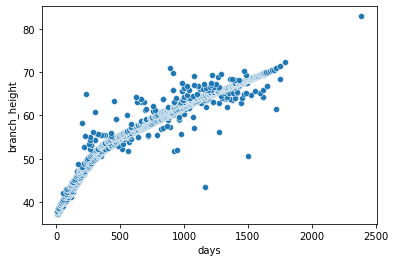

In [110]:
sns.scatterplot(data=df, x="days", y="branch_height")

It seems that the independent branch **behaves completely defferently depending on the dataset**: 
- **On Guinee data**, the branch seems to **regulate** the predictions made **from the image**, for both **Height** and **Width**. But even if we think so, it does that **wrongly** since even **if the img prediction is higher than the true value, the branch prediction increases the output value**. 
- **On Cambodge data**, the branch seems to **estimate an overall measure** of **height** and **weight**, then gets a **complementary information** from the img prediction to get **near the true value**. The behaviour here is more **accurate and gets good results**.

In [258]:
print('For Guinee :')
print('')

y_true = guinee_with_branch[['true_height','true_weight']].values

print('By using only the image predictions: ')
img_pred = guinee_with_branch[['img_height','img_weight']].values
mean_height_relative_error,mean_weight_relative_error,_ = calculate_mean_absolute_error_results(y_true,img_pred)
print(f'    Mean Relative Error:   for height: {mean_height_relative_error}')
print(f'                           for weight: {mean_weight_relative_error}')
print(50*'-')
print('By using both image predictions and branch predictions: ')
branch_pred = guinee_with_branch[['branch_height','branch_weight']].values
mean_height_relative_error,mean_weight_relative_error,_ = calculate_mean_absolute_error_results(y_true,branch_pred+img_pred)
print(f'    Mean Relative Error:   for height: {mean_height_relative_error}')
print(f'                           for weight: {mean_weight_relative_error}')

For Guinee :

By using only the image predictions: 
    Mean Relative Error:   for height: 0.08795762777016933
                           for weight: 0.20607917763718525
--------------------------------------------------
By using both image predictions and branch predictions: 
    Mean Relative Error:   for height: 0.10163020401823077
                           for weight: 0.20071238939550629


Suprisingly, we can see from above that for **Guinee data**, the model performs **worst when using the branch predictions**, and thus when using **SEX** and **AGE** attributes.

In [259]:
print('For Cambodge :')
print('')
y_true = cambodge_with_branch[['true_height','true_weight']].values
print('By using only the branch predictions: ')
branch_pred = cambodge_with_branch[['branch_height','branch_weight']].values
mean_height_relative_error,mean_weight_relative_error,_ = calculate_mean_absolute_error_results(y_true,branch_pred)
print(f'    Mean Relative Error:   for height: {mean_height_relative_error}')
print(f'                           for weight: {mean_weight_relative_error}')
print(50*'-')
print('By using both image predictions and branch predictions: ')
img_pred = cambodge_with_branch[['img_height','img_weight']].values
mean_height_relative_error,mean_weight_relative_error,_ = calculate_mean_absolute_error_results(y_true,branch_pred+img_pred)
print(f'    Mean Relative Error:   for height: {mean_height_relative_error}')
print(f'                           for weight: {mean_weight_relative_error}')

For Cambodge :

By using only the branch predictions: 
    Mean Relative Error:   for height: 0.2806609704239481
                           for weight: 0.2957280287513091
--------------------------------------------------
By using both image predictions and branch predictions: 
    Mean Relative Error:   for height: 0.03659841060185484
                           for weight: 0.09776654982694764


**In contrast** to what we saw with Guinee data, the **independent branch** when used on **Cambodge data improves the model** and uses the **image prediction** to **regulate and correct its predictions**.

## III- Conclusion

We saw that using **OpenPose**'s **Part Affinity Fields (PAFs)** which represent the **connected joints** as **input** to our **predictive model** has given us very **bad results**. But when we used **Mobilenet_v1** which is the **first block** in the **OpenPose model**, we achieved largely **better performances** for **guinee data**: a **mean height relative error** of almost **6%** against **46%** before, and a **mean weight relative error** of **22%** against **47%** before.

We then switched to **Mobilenet_v2**, which is known to have **better** overall performances than **Mobilenet_v1**. This led us to **improve** even more our results, and be able to reach **7%** and **19.6%** of **MRE on height and weight** respectively. We noted that the model was  **gaining more insights in predicting height** since it doesn't **output the mean** value like it did before, but now **follows the variations of the true values**. And when trained on images with **higher dimensions (384x384)**, the model performed even better and **gained 1% in predicting Height**.

Finally, we **integrated** the previously droped features, **AGE and SEX**. Adding them to **Fully Connected Layers** of our model **didn't improve** the results, neither for guinee , nor for cambodge. But when using an **Independent Branch**, our model performed **significantly better** with **Cambodge** data from **(5.8% , 11.6%)** to **(3.4%,9.1%)** , but worst on **Guinee** data. This behaviour may be explained by the fact that, as we've seen when describing the data, **AGE is significantly correlated with both height and weight in Cambodge data**, but in **Guinee data both AGE and SEX are uncorrelated with Height and Weight**. This explains why the predictions **using only the images led to better results for new born childs**. It may be that **new-borns** gain **less weight** during their first months compared to after. This would explain the **uncorrelation between the features**. Apart from that, the **size of Guinee dataset** with only **766 images** is only **10%** of the size of **Cambodge dataset (7641 images)**. So, we cannot draw conclusions, but we can hopefully **achieve better results** by getting more new born images. 

## IV- Future Work

1. We can use cambodge data better by training our model on **selected images** of new_borns or very young childs or lying childs..etc then **fine-tune** on guinee using **Mobilenet_v2**. 
2. We can also try **Ensemble Regression** and **combine several models** in order to improve the prediction accuracy.
3. Use a model to learn **depth features** of the images : [**MiDaS**](https://pytorch.org/hub/intelisl_midas_v2/) computes **relative inverse depth from a single image**. Using depth as feature may help our model and improve predictions. Example output:  ![alt](midas_output.png)
